# Introduction:
publicly available data from LendingClub.com. Lending Club connects people who need money (borrowers) with people who have money (investors). Hopefully, as an investor you would want to invest in people who showed a profile of having a high probability of paying you back.

We will use lending data from 2007-2010 and be trying to classify and predict whether or not the borrower paid back their loan in full. You can download the data from here.

Here are what the columns represent:

1. credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
2. purpose: The purpose of the loan (takes values "creditcard", "debtconsolidation", "educational", "majorpurchase", "smallbusiness", and "all_other").
3. int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
4. installment: The monthly installments owed by the borrower if the loan is funded.
5. log.annual.inc: The natural log of the self-reported annual income of the borrower.
6. dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
7. fico: The FICO credit score of the borrower.
8. days.with.cr.line: The number of days the borrower has had a credit line.
9. revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
10. revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
11. inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
12. delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
13. pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

# Objectives:
1. Get insights from the data using exploratory data analysis
2. Build a Machine Learning model to predict if a loan would be paid in full

# Exploratory Data Analysis:

## Load packages:

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, make_scorer
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from joblib import dump, load

## Load Data:

In [4]:
ld = pd.read_csv("../data/loan_data.csv")
print("Number of observations in the dataset: " + str(ld.shape[0]))
print("Number of columns in the dataset: " + str(ld.shape[1]))

Number of observations in the dataset: 9578
Number of columns in the dataset: 14


In [5]:
ld.head(10)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
5,1,credit_card,0.0788,125.13,11.904968,16.98,727,6120.041667,50807,51.0,0,0,0,0
6,1,debt_consolidation,0.1496,194.02,10.714418,4.00,667,3180.041667,3839,76.8,0,0,1,1
7,1,all_other,0.1114,131.22,11.002100,11.08,722,5116.000000,24220,68.6,0,0,0,1
8,1,home_improvement,0.1134,87.19,11.407565,17.25,682,3989.000000,69909,51.1,1,0,0,0
9,1,debt_consolidation,0.1221,84.12,10.203592,10.00,707,2730.041667,5630,23.0,1,0,0,0


## Clean Data:
#### In this step we are going to check if we have any missing values and if any data type conversion might be necessary

In [6]:
ld.isna().sum(axis=0)

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

#### Great! We do not have any missing values

In [7]:
ld.dtypes

credit.policy          int64
purpose               object
int.rate             float64
installment          float64
log.annual.inc       float64
dti                  float64
fico                   int64
days.with.cr.line    float64
revol.bal              int64
revol.util           float64
inq.last.6mths         int64
delinq.2yrs            int64
pub.rec                int64
not.fully.paid         int64
dtype: object

#### All of the features are numeric except purpose which is string. During modeling we will convert it to numeric using OneHotEncoder

In [8]:
ld_purpose = ld.groupby(['purpose'])['not.fully.paid'].value_counts().unstack()
ld_purpose = ld_purpose.reset_index()
ld_purpose.columns = ['purpose','paid','not_fully_paid']
ld_purpose.index.rename('',inplace=True)
ld_purpose['%paid']=ld_purpose.apply(lambda x: round((x.paid/(x.paid+x.not_fully_paid))*100, 2), axis=1)
ld_purpose['%not_fully_paid']=ld_purpose.apply(lambda x: round((x.not_fully_paid/(x.paid+x.not_fully_paid))*100, 2), axis=1)
ld_purpose['%of_all_loans']=round((ld_purpose.paid + ld_purpose.not_fully_paid)/ld.shape[0], 2)
ld_purpose

,purpose,paid,not_fully_paid,%paid,%not_fully_paid,%of_all_loans
,,,,,,
0,all_other,1944,387,83.40,16.60,0.24
1,credit_card,1116,146,88.43,11.57,0.13
2,debt_consolidation,3354,603,84.76,15.24,0.41
3,educational,274,69,79.88,20.12,0.04
4,home_improvement,522,107,82.99,17.01,0.07
5,major_purchase,388,49,88.79,11.21,0.05
6,small_business,447,172,72.21,27.79,0.06


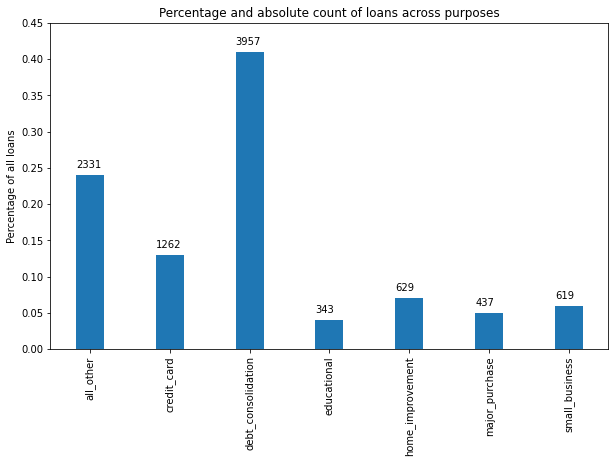

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(len(ld_purpose.purpose))
width = 0.35
rects = ax.bar(x, ld_purpose['%of_all_loans'], width=width)
ax.set_xticks(x)
ax.set_xticklabels(ld_purpose.purpose, rotation=90)
ax.set_ylim([0, 0.45])
ax.set_ylabel("Percentage of all loans")
ax.set_title("Percentage and absolute count of loans across purposes")

labels = list(ld_purpose.paid + ld_purpose.not_fully_paid)

for rect, label in zip(rects, labels):
    y = rect.get_height()
    x = rect.get_x()
    ax.text(x, y + 0.01, label)
plt.savefig("../static/purpose.png", dpi=1200)    
plt.show()

1. Debt consolidation loans present largest share(41%) of the approved loans at lendingtree
2. Educational loans present smallest share(4%) of the approved loans

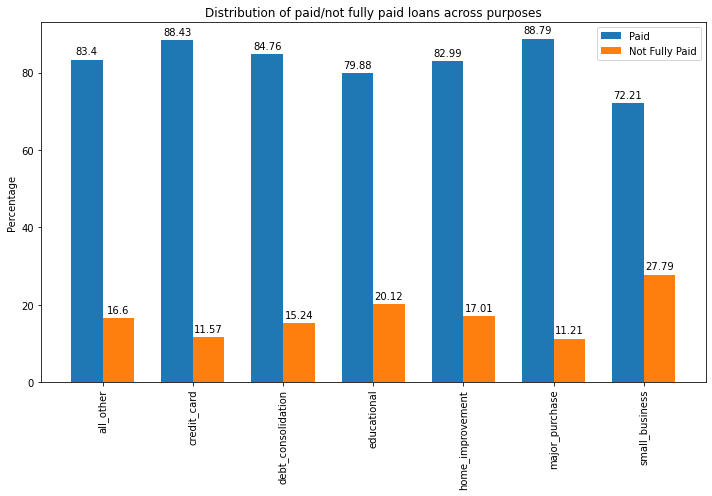

In [10]:
def plot_bar_charts(df, col):
    labels = df[col]
    paid = df['%paid']
    not_fully_paid = df['%not_fully_paid']
    
    x = np.arange(len(df.purpose))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10,7))
    
    rect1 = ax.bar(x-width/2, paid, width=width, label='Paid')
    rect2 = ax.bar(x+width/2, not_fully_paid, width=width, label='Not Fully Paid')
    
    ax.set_title("Distribution of paid/not fully paid loans across purposes")
    ax.set_ylabel("Percentage")
    ax.set_ylim([0,93])
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    
    ax.legend(loc = 'upper right')
    
    ax.bar_label(rect1, padding=3)
    ax.bar_label(rect2, padding=3)
    
    fig.tight_layout()
    plt.savefig("../static/purpose_paid_not_paid.png", dpi=1200)
    plt.show()

plot_bar_charts(ld_purpose, 'purpose')

1. Small Business loans have the highest percentage of not fully paid loans at 28%
2. Major purchases have the lowest percentage of not fully paid loans at 11%

In [11]:
# def make_box_plot(colname, label, df):
#     paid = df.loc[df['not.fully.paid']==0, colname]
#     not_fully_paid = df.loc[df['not.fully.paid']==1, colname]
    
#     fig, ax = plt.subplots(figsize=(10,6))
#     bp1 = ax.boxplot(paid, patch_artist=True, positions=[1], boxprops = dict(facecolor='green', color='green'))
#     bp2 = ax.boxplot(not_fully_paid, positions=[2], patch_artist=True, boxprops=dict(facecolor='red', color='red'))

#     ax.set_ylabel(label)
#     ax.set_xticklabels(['Paid','Not Fully Paid'])
    
#     plt.show()

In [12]:
ld_column_key = {'purpose':'Purpose', 'int.rate':'Interest Rate of Loan', 'installment':'Monthly Installment', 'log.annual.inc':'Natural Log of Annual Income', 'dti':'Debt to Income Ratio', \
                 'fico':'Fico Credit Score', 'days.with.cr.line':'Number of Days with a Credit Line', 'revol.bal':'Revolving Credit Line Balance', 'revol.util':'Revolving Credit Line Utilization',\
                 'inq.last.6mths':'Number of Inquiries in last 6 Months', 'delinq.2yrs':'Number of Deliquencies in Last 2 yrs.', 'pub.rec':'Number of Derogatory Public Records'}

#credit_policy dict
credit_policy_dict= {0:'Underwriting criteria did not meet', 1:'Underwriting criteria met'}

In [13]:
def make_box_plot(colname, label, df, ld_column_key=ld_column_key):
    fig, ax = plt.subplots(4, 3, figsize=(18,14))
    i = 0
    j = 0
    
    for col in colname:
        paid = df.loc[df['not.fully.paid']==0, col]    
#         quantiles = paid.quantile([0.25, 0.50, 0.75]).values
        bp1 = ax[i,j].boxplot(paid, patch_artist=True, positions=[1], boxprops = dict(facecolor='green', color='green'))
#         ax[i,j].text(1, quantiles[0], s = str(quantiles[0]))
#         ax[i,j].text(1, quantiles[1], s = str(quantiles[1]))
#         ax[i,j].text(1, quantiles[2], s = str(quantiles[2]))
        
        not_fully_paid = df.loc[df['not.fully.paid']==1, col]
        bp2 = ax[i,j].boxplot(not_fully_paid, positions=[2], patch_artist=True, boxprops=dict(facecolor='red', color='red'))

        ax[i, j].set_ylabel(ld_column_key.get(col))
        ax[i, j].set_xticklabels(['Paid','Not Fully Paid'])
#         ax[i, j].grid(axis='y')
        
        j = j + 1
        if j == 3:
            i = i +1
            j = 0
    
    fig.delaxes(ax=ax[3,2])
    plt.savefig("../static/box_plot.png", dpi=800, bbox_inches="tight")
    plt.show()

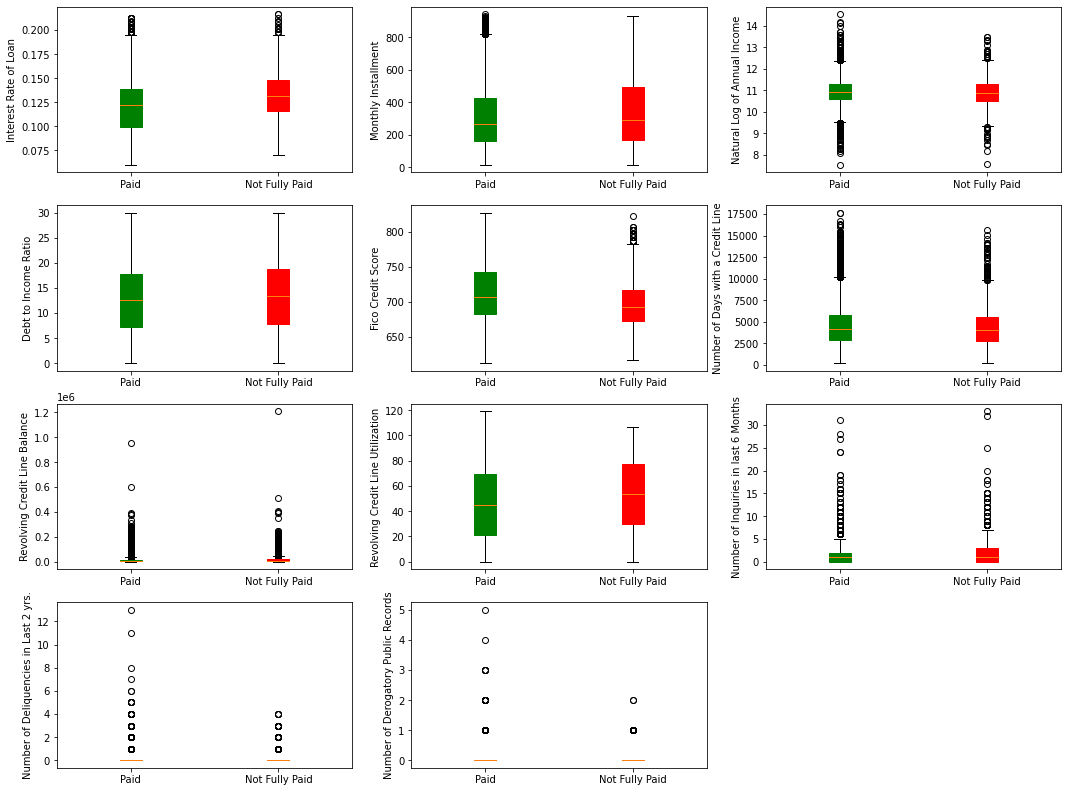

In [14]:
colnames = ['int.rate','installment','log.annual.inc','dti','fico','days.with.cr.line', 'revol.bal','revol.util', 'inq.last.6mths','delinq.2yrs','pub.rec']
make_box_plot(colnames, 'label', ld)

1. We see that full loan payment is associated with slightly
    1. lower interest rate 
    2. higher FICO credit score
    3. lower credit line utilization
    4. lower Debt to Income ratio
2. It is worth noting that the median values of the aforementioned features do not differ by much for the loans that were not paid in full
3. We see quite a few outlier associated with most of the features. We will take care of them we normalize our training data during modeling
4. These boxplots show that median values of the features are very close for paid and unpaid loans. I will try histograms to see if they reveal something

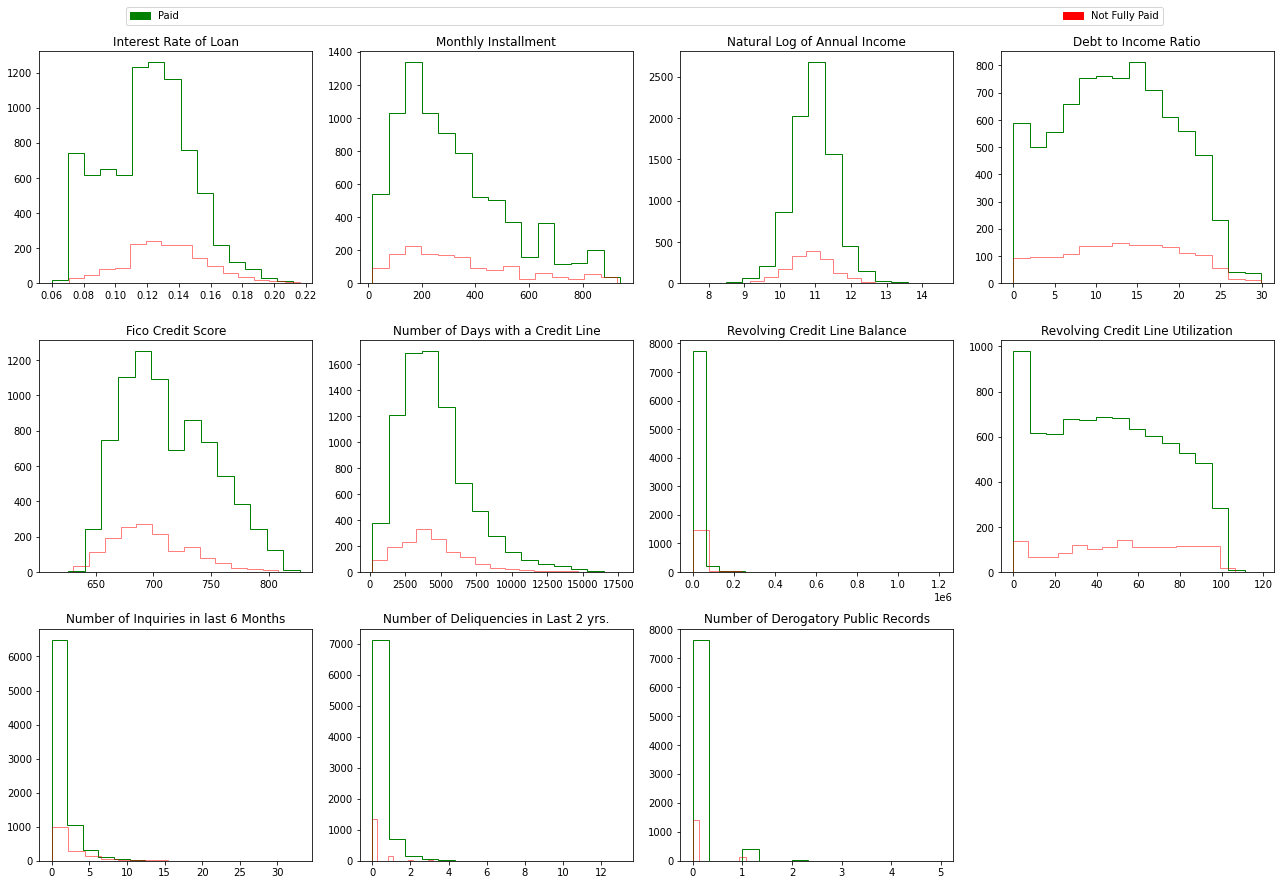

In [15]:
paid_patch = mpatches.Patch(color='g', label='Paid')
not_fully_paid_patch = mpatches.Patch(color='r', label='Not Fully Paid')

fig, ax = plt.subplots(3,4, figsize=(18,12))
i, j = 0 ,0

for col in ['int.rate','installment','log.annual.inc','dti','fico','days.with.cr.line', 'revol.bal','revol.util', 'inq.last.6mths','delinq.2yrs','pub.rec']:
    ax[i, j].hist(ld.loc[ld['not.fully.paid']==0, col], bins=15, color='g', histtype='step');
    ax[i, j].hist(ld.loc[ld['not.fully.paid']==1, col], bins=15, alpha=0.5, color='r', histtype='step');
    ax[i, j].set_title(ld_column_key.get(col))
    
    j = j + 1
    if j==4:
        i = i + 1
        j =0

    fig.tight_layout()
fig.legend(handles = [paid_patch, not_fully_paid_patch], bbox_to_anchor=(0.1, 1, 0.8, .8), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)

fig.delaxes(ax=ax[2,3])
plt.savefig("../static/histogram.png", dpi=800, bbox_inches="tight")
plt.show()

The distribution of the features are very similar for paid and unpaid loans. It would be interesting to see how a model performs with this dataset

In [16]:
ld['credit.policy'].value_counts()

1    7710
0    1868
Name: credit.policy, dtype: int64

It appears that some loans (1868) were approved even when the customer did not meet the credit underwriting criteria. Not sure why a loan would be approved if credit criteria was not met ?? Let's see what happened to those loans

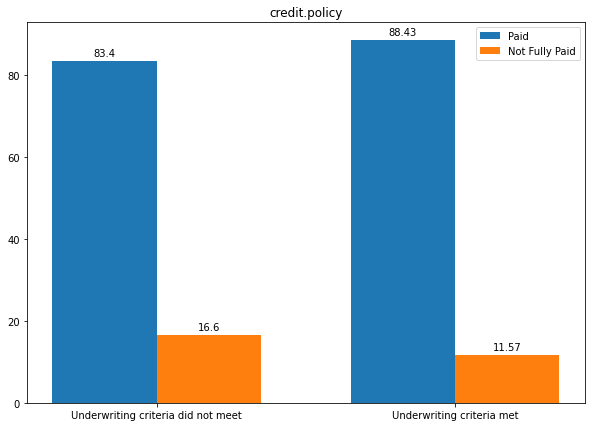

In [17]:
def plot_bar_chart_binary_col(df, col):
    df = ld.groupby([col])['not.fully.paid'].value_counts().unstack()    
    df = df.reset_index()
    df.columns = [col,'paid','not_fully_paid']
    df.index.rename('',inplace=True)
    df['%paid']=ld_purpose.apply(lambda x: round((x.paid/(x.paid+x.not_fully_paid))*100, 2), axis=1)
    df['%not_fully_paid']=ld_purpose.apply(lambda x: round((x.not_fully_paid/(x.paid+x.not_fully_paid))*100, 2), axis=1)    
    
    #plot bar chart
    labels = df[col].map(credit_policy_dict)
    paid = df['%paid']
    not_fully_paid = df['%not_fully_paid']
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10,7))
    
    
    rect1 = ax.bar(x - width/2, paid, width=width, label='Paid')
    rect2 = ax.bar(x + width/2, not_fully_paid, width=width, label="Not Fully Paid")
    
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    
    ax.bar_label(rect1, padding=3)
    ax.bar_label(rect2, padding=3)
    
    ax.set_title(col)
    
    plt.legend()
    plt.savefig('../static/credit_policy.png', dpi=1200)
    plt.show()
    
plot_bar_chart_binary_col(ld, 'credit.policy')    

Credit underwriting criteria does not appear to be making a big difference here. 88% of the loans where paid when credit criteria was met and 83% of loans were paid when criteria was not met. A mere difference of 5%. We do not have the loan amount but we do have the installment. We might need to check if 
the installment amount is low for approved loans when credit criteria was not met.

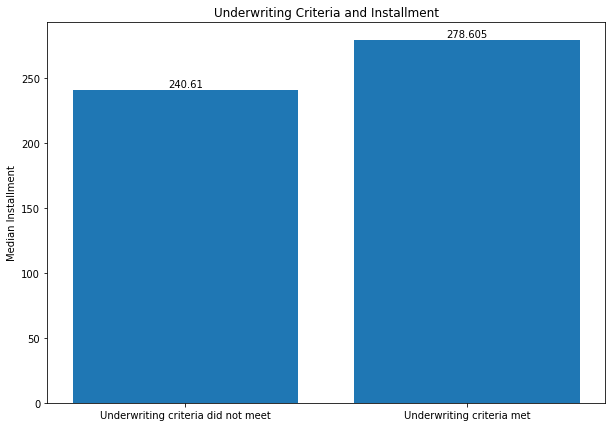

In [18]:
installment = ld.groupby(['credit.policy']).agg(avg_installment=('installment','median')).reset_index()
fig, ax = plt.subplots(figsize=(10, 7))
x = installment['credit.policy']
labels = installment['credit.policy'].map(credit_policy_dict)
rect = ax.bar(x, installment.avg_installment)
ax.set_xticks(x)
ax.bar_label(rect, padding=1)
ax.set_xticklabels(labels)
ax.set_ylabel("Median Installment")
ax.set_title("Underwriting Criteria and Installment")
plt.savefig("../static/installment.png", dpi=1200)
plt.show()

Median installment amount for customers who did not meet credit criteria is about 14% lower than that of customers who met the criteria. Installment amount could be lower or higher depending upon the length and amount of the loan but we do not have that information

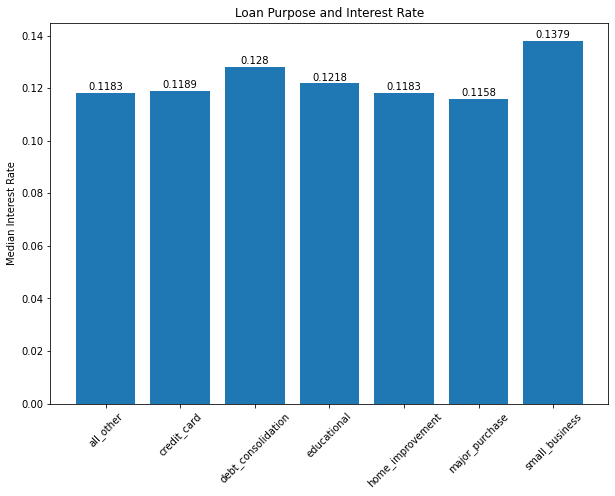

In [19]:
int_rate = ld.groupby(['purpose']).agg(avg_int_rate=('int.rate','median'))
x = np.arange(int_rate.shape[0])
labels = int_rate.index
fig, ax = plt.subplots(figsize=(10,7))
rect = ax.bar(x, int_rate.avg_int_rate)
ax.set_xticks(x)
ax.bar_label(rect, padding=1)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel("Median Interest Rate")
ax.set_title("Loan Purpose and Interest Rate")
plt.savefig("../static/int_rate.png", dpi=1200, bbox_inches="tight")
plt.show()

1. Median interest rate was highest at 0.1379 for small business loans
2. Major purchase loans had the lowest interest rate at 0.1158

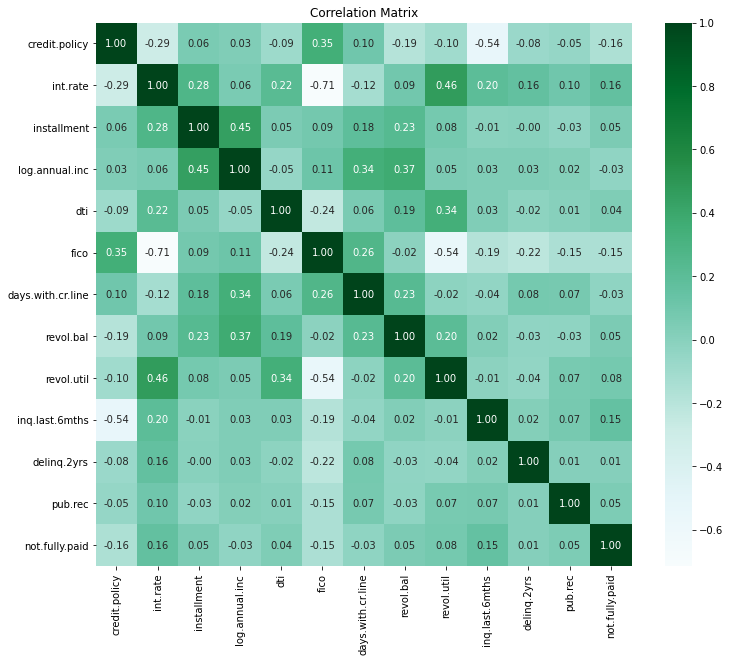

In [20]:
plt.figure(figsize=(12,10))
sns.heatmap(ld.corr(), annot=True, fmt='.2f', cmap='BuGn')
plt.title("Correlation Matrix")
plt.savefig("../static/correlation.png", dpi=1200, bbox_inches="tight")
plt.show()

Interest rate and Fico score show the highest correlation(-ve) of -0.71 meaning customers with high fico score get lower interest rate on their loan. Interest rate is also positively correlated with revolving credit line utilization. Higher utilization means high interest rate. Some other sets of features show some correlation as well:
1. Inquiry in last 6 months and customer meeting credit underwriting criteria are negatively correlated(-0.54): Less number of inquiries results in higher chances of meeting credit criteria
2. Revolving utlization and Fico score are negatively correlated (-0.54): Low credit utilization results in higher FICO score

## EDA Summary:

1. Debt consolidation loans present largest share(41%) of the approved loans at lendingtree
2. Educational loans present smallest share(4%) of the approved loans
3. Small Business loans have the highest percentage of not fully paid loans at 28%
4. Major purchases have the lowest percentage of not fully paid loans at 11%
5. Not fully paid loans have slightly higher interest rate, lower FICO score, higher credit line utilization and higher debt to income ratio compared to paid loans. However, the median values don't differ by much in paid and not fully paid groups.
6. 19.5% (1868) of the 9578 loans were approved for customers who did not meet company's credit underwriting criteria. 88% of the loans that were approved to customers meeting credit underwriting criteria paid off completely whereas 83% of the loans were completely paid off by the customers who did not meet the credit underwriting criteria. 
7. Median installment amount for customers who did not meet credit criteria is about 14% lower than that of customers who met the criteria. Installment amount could be lower or higher depending upon the length and amount of the loan but we do not have that information
8. Median interest rate was highest at 0.1379 for small business loans
9. Major purchase loans had the lowest interest rate at 0.1158

# Modeling

It is very important to check if we have a balanced dataset before we build a classification model. 

In [21]:
ld.groupby('not.fully.paid').dti.count()/ld.shape[0]

not.fully.paid
0    0.839946
1    0.160054
Name: dti, dtype: float64

...And we have an imbalanced dataset. 84% of the loans were fully paid while 16% were not fully paid. It is easy to build a model that will always predict that a loan will be paid in full and it will still be correct 84% of the time i.e. accuracy of 84%. Accuracy is not the right metric to use here because we want to be able to correctly predict when a loan will be paid in full and when not paid in full. Some business input/knowledge is needed to strike a balance between False Positives and False Negatives. There are a couple of choices here:
1. After splitting training and test data, we can oversample the under represented class i.e. loans that were not fully paid in our case to have a balanced dataset
2. Another option is to use AUC (Area under curve) as a measure of performance for the model.

I will be using AUC for my models. Here are some of the definitions related to AUC

* FP: False Postive -> Incorrectly predicted  as positive
* TP: True Positive -> Correctly predicted as positive
* FN: False Negative -> Incorrectly predicted in negative
* TN: True Negative -> Correctly predicted as negative
$$FPR = FP/(FP+TN)$$
$$TPR = TP/(TP+FN)$$
AUC is a plot between FPR and TPR. The higher the area under curve (AUC) the model is a better classifier to distinguish between classes

We will build two classes by extending BaseEstimator and TransformerMixing classes from sklearn packages. These will create two sets of features, one with numerical feature and other one with categorical features. 

In [22]:
class CategoricalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.select_dtypes(include='object')
        return X
    
    
class NumericalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.select_dtypes(include=np.number)
        return X

In [23]:
random_state=7

X = ld.drop(['not.fully.paid'], axis=1)
y = ld['not.fully.paid'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state, stratify=y)

X_train = X_train.copy()
X_test = X_test.copy()
y_train = y_train.copy()
y_test = y_test.copy()

Let's just make sure that training set got all possible values of purpose. The model would not work if test data contained new value of purpose that it not trained on

In [24]:
print(X_train.purpose.nunique())
print(ld.purpose.nunique())

7
7


In [25]:
pipeline_numerical = Pipeline(steps=
                                  [('numerical_features', NumericalFeatures()),
                                   ('standard_scaler', StandardScaler())
                                   ])

pipeline_categorical = Pipeline(steps=
                                    [('categorical_features', CategoricalFeatures()),
                                     ('OneHotEncoder', OneHotEncoder())
                                     ]
                                    )
pipeline_preprocessing = FeatureUnion(
        [('numerical', pipeline_numerical),
         ('categorical', pipeline_categorical)
         ]
    )

In [26]:
results = []
random_state = 7
def check_model_accuracy(name, model, param_grid):
    pipeline = Pipeline(steps=
                       [
                        ('preprocessing',pipeline_preprocessing),
                        (model[0], model[1])   
                       ]
                       )
    gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc', cv = 3, verbose=0, n_jobs=-1, error_score='raise')
    gs.fit(X_train, y_train)
    
    y_prob = gs.predict_proba(X_test)[:,1]    
    auc_score = roc_auc_score(y_test, y_prob)
    results.append([name, gs, auc_score])
    print(name + " AUC score is " + str(auc_score))

## RandomForestClassifier

In [27]:
model = ('rf', RandomForestClassifier())
param_grid = {
              'rf__criterion' : ['gini','entropy'],
              'rf__random_state' : [random_state] ,
              'rf__n_estimators' : range(100,1000,100),
              'rf__max_depth': range(2,8,2)
}
check_model_accuracy('RandomForest', model, param_grid)

RandomForest AUC score is 0.6855736158376234


## KNeighborsClassifier

In [28]:
model = ("knn", KNeighborsClassifier())
param_grid = {
              'knn__n_neighbors':range(10,100, 5),
              'knn__p':range(1,3)
}
check_model_accuracy('KNN', model, param_grid)

KNN AUC score is 0.6726556442486583


# SGDClassifier

In [29]:
model = ('sgd',SGDClassifier())
param_grid = {
             'sgd__loss':['hinge','log','perceptron'],
             'sgd__random_state':[random_state],
             'sgd__penalty': ['l1','l2','elasticnet'],
             'sgd__alpha': np.linspace(0.0001,1, 100)
}
check_model_accuracy('SGDClassifier', model, param_grid)

SGDClassifier AUC score is 0.6766620171956199


# GradientBoostingClassifier

In [30]:
model = ('GB', GradientBoostingClassifier())
param_grid = {
              'GB__learning_rate':np.linspace(0.1,1,25),
              'GB__max_depth':[3,4,5],
              'GB__random_state':[random_state]
}
check_model_accuracy('GradientBoosting', model, param_grid)

GradientBoosting AUC score is 0.6792340721875929


# LogisticRegression

In [31]:
model = ('LR',LogisticRegression())
param_grid = {
              'LR__random_state':[random_state],
              'LR__C': np.linspace(0.001, 5, 100)              
}
check_model_accuracy('LogisticRegression', model, param_grid)

LogisticRegression AUC score is 0.6871547059192691


# XGBClassifier

In [32]:
model = ('XGB', XGBClassifier())
param_grid = {
              'XGB__learning_rate':np.linspace(0.01, 1, 50)
}
check_model_accuracy('XGBClassifier', model, param_grid)

XGBClassifier AUC score is 0.675652832297156


# Conclusion

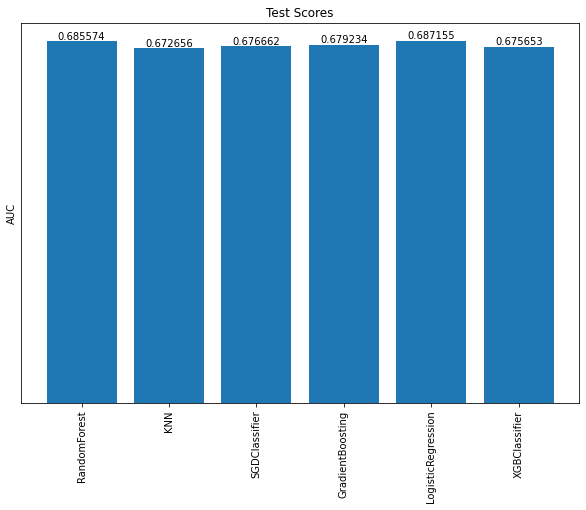

In [33]:
model_score = pd.DataFrame([[r[0],r[2]] for r in results], columns=['model','auc_score'])
fig, ax = plt.subplots(figsize=(10,7))
x = np.arange(model_score.shape[0])
rects = plt.bar(x, model_score.auc_score)
ax.bar_label(rects)
ax.set_xticks(x)
ax.set_xticklabels(model_score.model, rotation=90)
ax.set_yticks([])
ax.set_ylabel("AUC")
ax.set_title("Test Scores")
plt.savefig("../static/results.png", dpi=1200, bbox_inches="tight")
plt.show()

* All of the models are performing almost equally
* LogisticRegression classification resulted in highest AUC score 0.69
* AUC score between 0.6 and 0.7 is generally considered a fair score whereas AUC above 0.9 is considered outstanding
* We can save the LogisticRegressionClassifier as pickled file and use it in an app for prediction

In [34]:
results[-2][1].best_params_

{'LR__C': 0.10198989898989898, 'LR__random_state': 7}

In [35]:
dump(results[-2][1],'../model/loan_data.pkl')

['../model/loan_data.pkl']